In [2]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [3]:
session_info = {'date': "05_02_2024",
                'genotype_dir': 'R18B05LexA_LexOpChrimson88tdT_R60D05_UASOpGCaMP6',
                'fly': 'fly1',
                'session': 'alternating_stim_points_2_6-024',
                'full_genotype': '+/UAS-opGCaMP6; R18B05-LexA/+; R60D05-Gal4/LexOpChrimson88::tdT',
                'ecl date': '',
                'notes':''}

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')
                            

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_base_dir = fictrac_folder)

In [4]:
pp.extract_metadata()
pp.bruker_to_h5(first_chan=1, overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
pp.align_voltage_recording()
nap = pp.open_napari()

(217, 273)
[                                        ] | 0% Completed | 747.54 ms

<tifffile.TiffFile 'alternating_sti…1_000006.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 


[########################################] | 100% Completed | 60.51 s


In [5]:
print('')

In [6]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

In [7]:
y = pp.calculate_zscored_F('rois', zscore=False, exp_detrend = True)

In [8]:
pp.save()

In [9]:
# y_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y, 3, axis=-1),.7,axis=1, mode='wrap')
y_sm = y-1  #sp.ndimage.gaussian_filter1d(y, 1, axis=-1)

x_f,y_f = st2p.utilities.pol2cart(y_sm[0,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
print(rho.shape, phi.shape)

heading = -1* pp.voltage_recording_aligned[' Heading'].to_numpy()

_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

(2847,) (2847,)


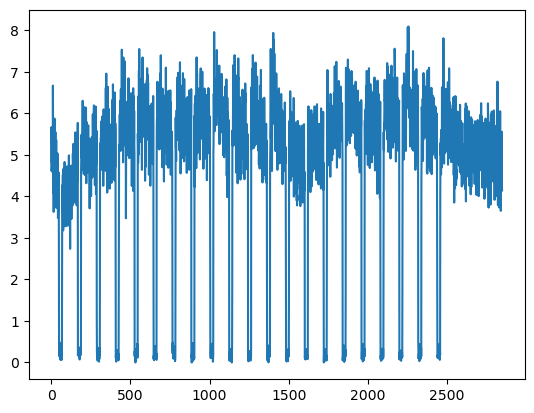

In [10]:
fig, ax= plt.subplots()
ax.plot(pp.timeseries['background'][1,0,:])

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Arena DAC1_cartx',
       ' Arena DAC1_carty'],
      dtype='object')
(2, 16, 2847) (2847,)


(array([212., 135., 149., 383., 679., 370., 158., 174., 247., 340.]),
 array([-3.13971152e+00, -2.51163472e+00, -1.88355792e+00, -1.25548112e+00,
        -6.27404317e-01,  6.72482501e-04,  6.28749282e-01,  1.25682608e+00,
         1.88490288e+00,  2.51297968e+00,  3.14105648e+00]),
 <BarContainer object of 10 artists>)

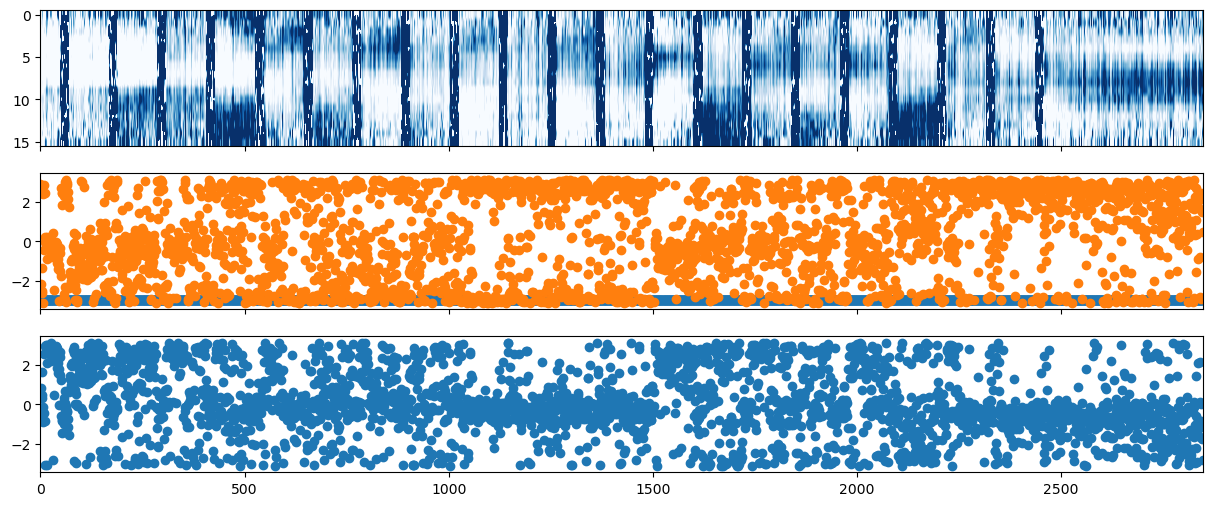

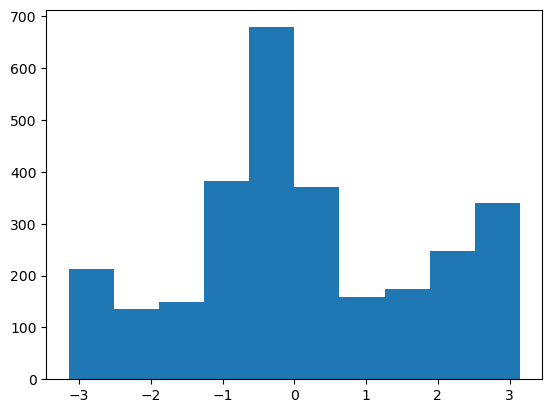

In [11]:
fig, ax= plt.subplots(3,1, figsize=[15,6], sharex=True)
ax[0].imshow(y_sm[1,:,:], aspect='auto', cmap= 'Blues', vmin=-.1,vmax=.7)
# ax.scatter(np.arange(y.shape[-1]), 15*(phi+np.pi)/2/np.pi)

print(pp.voltage_recording_aligned.columns)
# fig, ax= plt.subplots()

x = np.arange(y.shape[-1])
print(y.shape, heading.shape)
ax[1].scatter(x,heading)
ax[1].scatter(x, phi)
ax[2].scatter(x, offset)

mask = (heading>-3*np.pi/4) & (heading<3*np.pi/4)
fig, ax= plt.subplots()
ax.hist(offset[:])

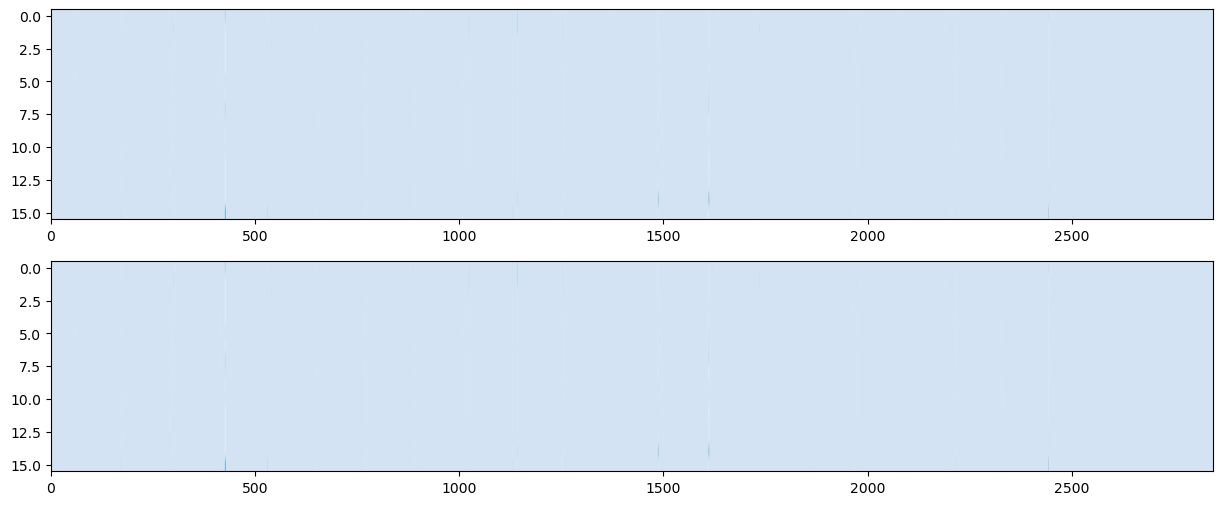

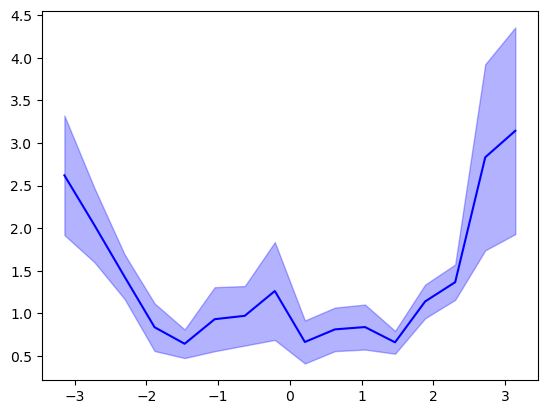

In [12]:
heading_ind = ((n_rois-1)*(heading+np.pi)/2/np.pi).astype(int)
# print(heading_ind, y_sm.shape)

y_sm_heading_aligned = np.zeros_like(y_sm)
for ind in range(heading.shape[0]):
    y_sm_heading_aligned[0,:,ind] = np.roll(y_sm[0,:,ind], -heading_ind[ind])
    
fig, ax= plt.subplots(2,1, figsize=[15,6])
ax[0].imshow(y_sm[0,:, :] - y_sm[0,:,:].mean(axis=0), cmap='Blues',aspect='auto')
ax[1].imshow(y_sm_heading_aligned[0,:,:] - y_sm[0,:,:].mean(axis=0), cmap='Blues',aspect='auto')

# y_sm_ha = y
mu = y_sm_heading_aligned[:,:,:].mean(axis=-1)[0,:]
sem = sp.stats.sem(y_sm_heading_aligned[:,:,:], axis=-1)[0,:]
# print(mu.shape, sem.shape)
# fig, ax = plt.subplots()
# ax.imshow(y_sm_heading_aligned[:,:,mask][0,:,:], cmap='Blues', aspect='auto')

fig, ax= plt.subplots()
ax.fill_between(np.linspace(-np.pi, np.pi, num=n_rois), mu-sem, mu+sem, alpha=.3, color='blue')
ax.plot(np.linspace(-np.pi, np.pi, num=n_rois), mu, color='blue')

In [12]:
print(sp.stats.circvar(offset[mask]))

0.9547642821534772
